# Tarea 1 Machine Learning - Métodos Lineales para Regresión

Juan Pablo Muñoz - 201373522-3 

Margarita Bugueño Pérez - 201373510-K

## 5. Detectar enfermedades cardíacas

El dataset contiene 13 atributos en lugar de las 75 que se consideran en el dataset original.  
Estas corresponden a:  

-- 1. age       
-- 2. sex       
-- 3. chest pain type  (4 values)       
-- 4. resting blood pressure  
-- 5. serum cholestoral in mg/dl      
-- 6. fasting blood sugar > 120 mg/dl       
-- 7. resting electrocardiographic results  (values 0,1,2) 
-- 8. maximum heart rate achieved  
-- 9. exercise induced angina    
-- 10. oldpeak = ST depression induced by exercise relative to rest   
-- 11. the slope of the peak exercise ST segment     
-- 12. number of major vessels (0-3) colored by flourosopy        
-- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect   

#### a. Cargar el dataset

In [33]:
import pandas as pd

headers = ['age','sex','chest_pain','blood_p','serum','blood_s','electro','max_heart', \
               'angina','oldpeak','slope','vessel','thal','normal']

df = pd.read_csv('heart.dat', header=None, names=headers, sep=' ')

# Reordenamiento aleatorio del dataset
#PROBAR RENDIMIENTO CON Y SIN SAMPLE
#df = df.sample(frac=1)

df.head()

,age,sex,chest_pain,blood_p,serum,blood_s,electro,max_heart,angina,oldpeak,slope,vessel,thal,normal
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


Se observa la serie de datos 'max_heart' con un boxplot para conocer cómo está distribuida y para identificar outliers.

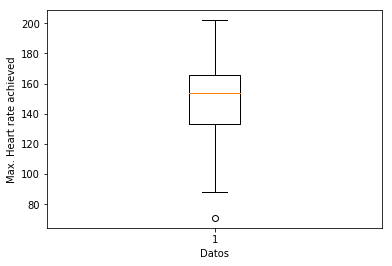

In [34]:
import matplotlib.pyplot as plt

plt.clf()

plt.boxplot(list(df['max_heart']))
plt.xlabel('Datos')
plt.ylabel('Max. Heart rate achieved')

plt.show()

Dada la baja presencia de outliers estadísticos (aquellos fuera del rango intercuartil ampliado por un factor de $1.5$ tanto por abajo como por arriba, lo que es casi como estar fuera del intervalo $[\bar{x}-3\sigma, \bar{x}+3\sigma]$), y asumiendo la distribución normal del atributo $x = max\_heart$, se relajará la condición para considerarse outlier a aquellos puntos $x$ fuera del intervalo $[\bar{x}-2\sigma, \bar{x}+2\sigma]$, con lo que se espera que el $4.56\%$ de los pacientes observados sean atípicos y posibles enfermos cardíacos. Notar que esta decisión se basa únicamente en el hecho de que $max\_heart$ sea un atípico de acuerdo al criterio definido, el cual incluye tanto pacientes con un muy alto ritmo cardíaco como a los con uno muy bajo.

In [23]:
def categorizar(vector_continuo):
    vector_clasificaciones = []
    for x in list(vector_continuo):
        if x < np.mean(vector_continuo) - 2*np.std(vector_continuo):
            vector_clasificaciones.append(1)
        elif x > np.mean(vector_continuo) + 2*np.std(vector_continuo):
            vector_clasificaciones.append(1)
        else:
            vector_clasificaciones.append(0)
    return vector_clasificaciones

In [24]:
import numpy as np

cantidad_outliers = sum(categorizar(df['max_heart']))

print('Cantidad outliers bajo nuevo criterio:',cantidad_outliers)

Cantidad outliers bajo nuevo criterio: 10


De acuerdo al criterio establecido, a partir de los datos, serían 10 pacientes los catalogados como outliers, siendo considerados enfermos (anteriormente sólo existía uno; el único del boxplot anterior). Entonces, se debe aplicar el mismo criterio sobre el modelo de regresión lineal que se va a crear. La idea es que la salida del modelo sea transformada de una continua a una del tipo categórica, con las clases {1=enfermo, 0=sano}. Así, una predicción será correcta si tanto el max_heart predicho como el real resultan ser outliers de sus respectivas series de datos.

Escalado y estandarización de los atributos.

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

Creación de la matriz de datos de entrada $X$ (todos los atributos excepto 'max_heart') y vector de salidas esperadas $Y$ (columna 'max_heart').

In [26]:
X = df.drop('max_heart', 1)
Y = df['max_heart']

Creación del conjunto de entrenamiento $(X_{train}, Y_{train})$ y el conjunto de pruebas $(X_{test}, Y_{test})$ con el 70% y el 30% de los datos, respectivamente.

In [27]:
corte = int(0.7*len(X))

Xtrain = X[:corte]
Ytrain = Y[:corte]
Xtest = X[corte:]
Ytest = Y[corte:]

Categorización de los vectores $Y_{train}$ e $Y_{test}$.

In [28]:
Ytrain_categorical = categorizar(Ytrain)
Ytest_categorical = categorizar(Ytest)

#### b. Regresión lineal

Generar el modelo de regresión lineal usando $(X_{train}, Y_{train})$.

In [29]:
import sklearn.linear_model as lm

Xtrain.insert(Xtrain.shape[1], 'intercept', np.ones(Xtrain.shape[0]))
Xtest.insert(Xtest.shape[1], 'intercept', np.ones(Xtest.shape[0]))
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(Xtrain, Ytrain)
linreg.coef_.reshape((-1,1))

array([[ -8.12514306e-01],
       [  2.82867606e+00],
       [ -1.40728342e-01],
       [  1.03873158e-01],
       [  4.09146709e-02],
       [  4.67997608e+00],
       [  1.25463401e+00],
       [ -1.08668835e+01],
       [ -2.66245037e-01],
       [ -7.68115033e+00],
       [  4.21669251e-01],
       [  9.16526153e-02],
       [ -1.34289996e+01],
       [  2.00104023e+02]])

In [30]:
from sklearn.metrics import accuracy_score

yhat_train = linreg.predict(Xtrain)
yhat_test = linreg.predict(Xtest)

yhat_train_categorical = categorizar(yhat_train)
yhat_test_categorical = categorizar(yhat_test)


print("Training Score:",round((accuracy_score(Ytrain_categorical,yhat_train_categorical)),4))
print("Test Score: ",round((accuracy_score(Ytest_categorical,yhat_test_categorical)),4))

Training Score: 0.9577
Test Score:  0.963


En promedio, un $93\%$ de las predicciones resultaron correctas. Si se revisan las indetecciones de enfermedad:

In [31]:
print('nº : y_true , y_pred')
for i in range(len(Ytrain_categorical)):
    if(Ytrain_categorical[i] == 1):
        print(i,':', Ytrain_categorical[i],',', yhat_train_categorical[i])

nº : y_true , y_pred
51 : 1 , 0
61 : 1 , 1
112 : 1 , 0
114 : 1 , 0
115 : 1 , 0
140 : 1 , 0


Sólo acertó a dos (dato 6 y 102). Comprobando el de test:

In [32]:
print('nº : y_true , y_pred')
for i in range(len(Ytest_categorical)):
    if(Ytest_categorical[i] == 1):
        print(i,':', Ytest_categorical[i],',', yhat_test_categorical[i])

nº : y_true , y_pred
13 : 1 , 1
48 : 1 , 0
64 : 1 , 0
71 : 1 , 0


No se acertó a ninguno.

### (discutir resultado y proponer otro método)